<a href="https://colab.research.google.com/github/1ngaa/lr/blob/main/%D0%BF%D0%BE%D0%BF%D1%8B%D1%82%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install torch torchvision pytorch-lightning umap-learn seaborn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Используется: cuda
GPU: Tesla T4


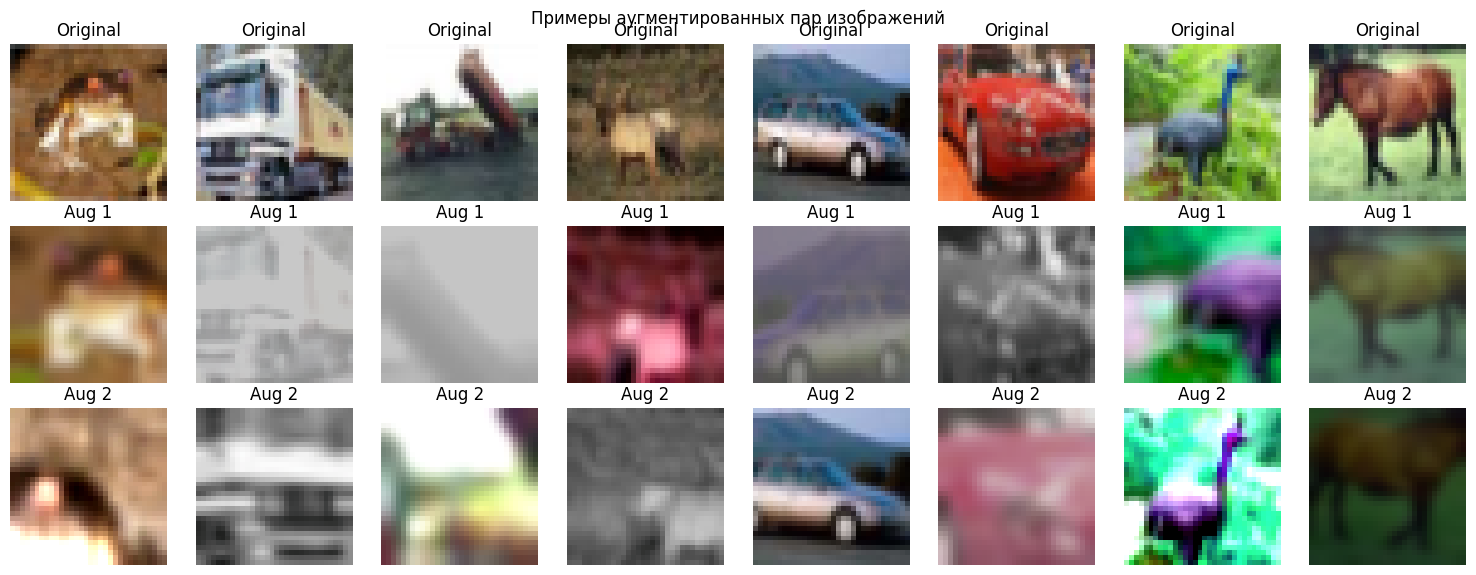

In [18]:
class SimCLRTransform:
    def __init__(self, size=32):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

def denormalize(tensor):
    """Денормализация изображений для визуализации"""
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1).permute(1, 2, 0)

# Визуализация аугментаций
def visualize_augmentations(dataset, transform, n_images=8):
    plt.figure(figsize=(15, 6))
    for i in range(n_images):
        # Оригинальное изображение
        img, _ = dataset[i]
        plt.subplot(3, n_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original")

        # Первая аугментация
        aug1, _ = transform(img)
        plt.subplot(3, n_images, i+1+n_images)
        plt.imshow(denormalize(aug1))
        plt.axis('off')
        plt.title("Aug 1")

        # Вторая аугментация
        _, aug2 = transform(img)
        plt.subplot(3, n_images, i+1+2*n_images)
        plt.imshow(denormalize(aug2))
        plt.axis('off')
        plt.title("Aug 2")

    plt.suptitle("Примеры аугментированных пар изображений", y=0.95)
    plt.tight_layout()
    plt.show()

# Загрузка данных для визуализации
temp_dataset = CIFAR10(root='./data', train=True, download=True)
temp_transform = SimCLRTransform()
visualize_augmentations(temp_dataset, temp_transform)

In [19]:
class Encoder(nn.Module):
    def __init__(self, encoder='resnet18'):
        super().__init__()
        self.model = torchvision.models.resnet18(weights=None)
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.feature_dim = 512

    def forward(self, x):
        return torch.flatten(self.model(x), 1)

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [20]:
class SimCLR(pl.LightningModule):
    def __init__(self, encoder='resnet18', hidden_dim=512, output_dim=128, temperature=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(encoder)
        self.projection = ProjectionHead(self.encoder.feature_dim, hidden_dim, output_dim)
        self.temperature = temperature
        self.train_loss_history = []

    def forward(self, x):
        h = self.encoder(x)
        return self.projection(h)

    def contrastive_loss(self, z_i, z_j):
        z = torch.cat([z_i, z_j], dim=0)
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / self.temperature
        sim_ij = torch.diag(sim, z_i.size(0))
        sim_ji = torch.diag(sim, -z_i.size(0))
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        negatives = sim[~torch.eye(2*z_i.size(0), dtype=bool, device=z.device)].reshape(2*z_i.size(0), -1)
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        labels = torch.zeros(2*z_i.size(0), dtype=torch.long, device=z.device)
        return F.cross_entropy(logits, labels)

    def training_step(self, batch, batch_idx):
        (x_i, x_j), _ = batch
        z_i = self(x_i)
        z_j = self(x_j)
        loss = self.contrastive_loss(z_i, z_j)
        self.train_loss_history.append(loss.item())
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)
        return [optimizer], [scheduler]

In [22]:
from pytorch_lightning import Trainer
train_dataset = CIFAR10(root='./data', train=True, transform=SimCLRTransform(), download=True)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
model = SimCLR()

trainer = Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1 if torch.cuda.is_available() else None,
    enable_progress_bar=True
)
print("\nНачинаем обучение...")
trainer.fit(model, train_loader)



INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | encoder    | Encoder        | 11.2 M | train
1 | projection | ProjectionHead | 329 K  | train
------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.023    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mod


Начинаем обучение...


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [23]:
# 5. Сохранение модели (ТОЛЬКО ПОСЛЕ ОБУЧЕНИЯ!)
torch.save({
    'model_state_dict': model.state_dict(),
    'encoder_state_dict': model.encoder.state_dict(),
    'projection_state_dict': model.projection.state_dict(),
}, 'simclr_model.pth')
print("Модель успешно сохранена")

Модель успешно сохранена


Извлечение SSL-признаков...

Извлечение сырых пикселей...

Оценка KNN классификатора:
На сырых пикселях:
Точность: 36.50%

На SSL-признаках:
Точность: 50.68%

Улучшение: +14.18%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


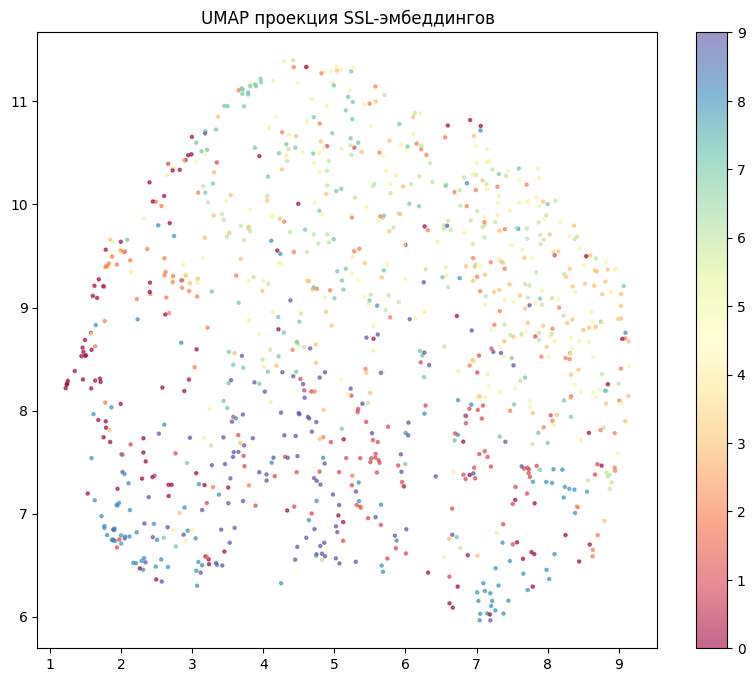

In [29]:
model = model.to(device)

# 1. Функция для извлечения сырых пикселей
def extract_raw_pixels(dataloader, max_samples=None):
    pixels, labels = [], []
    for x, y in dataloader:
        pixels.append(x.view(x.size(0), -1).cpu())  # Преобразуем в 1D вектор
        labels.append(y)
        if max_samples and len(pixels)*x.size(0) >= max_samples:
            break
    pixels = torch.cat(pixels)[:max_samples] / 255.0  # Нормализация [0,1]
    return pixels, torch.cat(labels)[:max_samples]

# 2. Улучшенная функция извлечения признаков
def extract_features(model, dataloader, max_samples=None, layer='encoder'):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        processed = 0
        for x, y in dataloader:
            x = x.to(device)
            h = model.encoder(x) if layer == 'encoder' else model(x)
            h = F.normalize(h, p=2, dim=1)
            features.append(h.cpu())
            labels.append(y)

            processed += x.size(0)
            if max_samples and processed >= max_samples:
                break

    return torch.cat(features), torch.cat(labels)

# 3. Оценка только KNN классификатора
def evaluate_knn(train_f, train_l, test_f, test_l, k=10):
    train_f = train_f.numpy() if torch.is_tensor(train_f) else train_f
    test_f = test_f.numpy() if torch.is_tensor(test_f) else test_f

    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1)
    knn.fit(train_f, train_l)
    return accuracy_score(test_l, knn.predict(test_f))

# 4. Подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2470, 0.2435, 0.2616])
])

train_dataset = CIFAR10(root='./data', train=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# 5. Извлечение признаков
print("Извлечение SSL-признаков...")
train_emb, train_lbl = extract_features(model, train_loader, 5000, 'encoder')
test_emb, test_lbl = extract_features(model, test_loader, 1000, 'encoder')

print("\nИзвлечение сырых пикселей...")
raw_train, raw_train_lbl = extract_raw_pixels(train_loader, 5000)
raw_test, raw_test_lbl = extract_raw_pixels(test_loader, 1000)

# 6. Оценка KNN
print("\nОценка KNN классификатора:")
print("На сырых пикселях:")
raw_knn_acc = evaluate_knn(raw_train, raw_train_lbl, raw_test, raw_test_lbl)
print(f"Точность: {raw_knn_acc:.2%}")

print("\nНа SSL-признаках:")
ssl_knn_acc = evaluate_knn(train_emb, train_lbl, test_emb, test_lbl)
print(f"Точность: {ssl_knn_acc:.2%}")
print(f"\nУлучшение: +{(ssl_knn_acc - raw_knn_acc):.2%}")


# 8. Визуализация UMAP
plt.figure(figsize=(10, 8))
reducer = umap.UMAP(n_components=2, metric='cosine', n_neighbors=15)
emb_2d = reducer.fit_transform(test_emb.numpy())
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=test_lbl.numpy(), cmap='Spectral', alpha=0.6, s=5)
plt.title('UMAP проекция SSL-эмбеддингов')
plt.colorbar()
plt.show()